Alkım Ege Akarsu | 21901461 | EEE 485 | Term Project
# Classification of Diabetic and Non-Diabetic Individuals Based on Survey Data
# Feedforward Neural Network
## Package Imports

In [97]:
import numpy as np  # For math operations
import pandas as pd  # For importing and handling datasets
import matplotlib.pyplot as plt  # For plotting
from mpl_toolkits.mplot3d import axes3d  # For 3D component of plotting

# Pandas options
pd.set_option("display.max_columns", None)
# NumPy options
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

## Functions

In [98]:
# DATASET PREPARATION
def train_test_split(dataset, train_fraction):
    """Split the dataset into train and test sets

    Args:
        dataset (DataFrame): All available data points.
        Label and features as columns, Datapoints as rows.
        train_fraction (float): Fraction of data
            points to be added to the training set.

    Returns:
        DataFrame: Training dataset
        DataFrame: Test dataset
    """
    # Randomly sample for train
    train = dataset.sample(frac=train_fraction, axis="index")
    # Subtract train from original
    test = dataset.drop(index=train.index)
    # Reset indexes
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)

    return train, test


def mini_dataset(dataset, fraction):
    """Return a fraction of the dataset.

    Args:
        dataset (DataFrame): Original dataset. Has shape (n, p).
        fraction (double): Fraction of dataset to return.

    Returns:
        DataFrame: Smaller dataset. Has shape (n / fraction, p).
    """
    return dataset.sample(frac=fraction, axis="index", ignore_index=True)


def standardize(train, test):
    """Standardize X matrices of train and test splits. Uses the mean and
    standard deviation of the training set to standardize both training
    and test sets. This prevents data leakage between training and test sets.

    Args:
        train (DataFrame): Training set.
        test (DataFrame): Test set.

    Returns:
        DataFrame: Standardized training set
        DataFrame: Standardized test set
    """
    # Get mean and standard deviation
    mean = train.mean()
    std = train.std()
    # Get results
    train_result = (train - mean) / std
    test_result = (test - mean) / std

    return train_result, test_result


def split_validation(X_train, y_train, valid_fraction):
    """Split a valdation set from a training set.

    Args:
        X_train (ndarray): Feature matrix. Has shape (n, p).
        y_train (ndarray): Label vector. Has shape (n, 1).
        valid_fraction (double): Fraction of data points to be added to the
            validation set.

    Returns:
        ndarray: Training features
        ndarray: Training labels
        ndarray: Validation features
        ndarray: Validation labels
    """
    # Calculate the number of validation samples
    num_validation_samples = int(X_train.shape[0] * valid_fraction)
    # Generate a random permutation of the indices
    indices = np.random.permutation(X_train.shape[0])
    # Split the indices into training and validation sets
    training_i, validation_i = (
        indices[num_validation_samples:],
        indices[:num_validation_samples],
    )
    # Use the indices to create the training and validation sets
    X_train, X_valid = X_train[training_i, :], X_train[validation_i, :]
    y_train, y_valid = y_train[training_i, :], y_train[validation_i, :]

    return X_train, y_train, X_valid, y_valid


# FEEDFORWARD NEURAL NETWORK
def initialize(layer_dimensions):
    """Initialize the weights and biases of the neural network.

    Args:
        layer_dimensions (list of ints): Contains the dimension of every layer.
            Ex: [4, 7, 4] Represents a network with 4 input, 7 hidden_2
            and 4 output layer neurons.

    Returns:
        dictionary of ndarrays: Contains the weights and biases of the neural network.
            Formatted as W1, b1, W2, b2 etc.
            Wl has shape (layer_dimensions[l], layer_dimensions[l - 1])
            bl has shape (layer_dimensions[l], 1)
    """
    # Dict containing weights and biases
    parameters = {}
    # Number of layers
    L = len(layer_dimensions)
    # Loop over each layer
    for l in range(1, L):
        # Initialize W and b
        # He weight initialization best for ReLu
        parameters["W" + str(l)] = np.random.normal(
            0,
            np.sqrt(2 / layer_dimensions[l - 1]),
            (layer_dimensions[l], layer_dimensions[l - 1]),
        )
        # Zero initialization for biases
        parameters["b" + str(l)] = np.zeros((layer_dimensions[l], 1))

    return parameters


def get_induced_local_field(A_previous, W, b):
    """Compute the induced local field.

    Args:
        A_previous (ndarray): Outputs of the previous layer or inputs.
            Has shape (previous layer, number of data points).
        W (ndarray): Weight matrix. Has shape: (current layer, previous layer)
        b (ndarray): Bias vector. Has shape: (current layer, 1)

    Returns:
        ndarray: Induced local field.
            Has shape (current layer, number of data points).
        tuple of ndarrays: Storage to be used in backward propagation
    """
    # Calculate induced local field.
    V = np.dot(W, A_previous) + b
    # Store results for faster backward propagation
    induced_local_field_storage = (A_previous, W, b)

    return V, induced_local_field_storage


def relu(V):
    """Calculate the output of the ReLu activation function given the induced
    local field.

    Args:
        V (ndarray): Induced local field.
            Has shape (current layer, number of data points).

    Returns:
        ndarray: Output of ReLu. Has shape (current layer, number of data points).
        ndarray: Storage to be used in backward propagation. Contains V.
    """
    # Get activation results of current layer
    A = np.maximum(0, V)
    # Store induced local field
    storage = V

    return A, storage


def sigmoid(V):
    """Calculate the output of the sigmoid activation function given the induced
    local field.

    Args:
        V (ndarray): Induced local field.
            Has shape (current layer, number of data points).

    Returns:
        ndarray: Output of sigmoid. Has shape (current layer, number of data points).
        ndarray: Storage to be used in backward propagation. Contains V.
    """
    # Get activation results of current layer
    A = 1 / (1 + np.exp(-V))
    # Store induced local field
    storage = V

    return A, storage


def relu_backward(dA, storage):
    """Backward propagation version of ReLu.

    Args:
        dA (ndarray): Gradient of activation.
        storage (ndarray): Only contains the induced local field.

    Returns:
        ndarray: Gradient of cost with respect to induced local field.
    """
    # Get induced local field from storage
    V = storage
    # Convert dA to dV
    dV = np.array(dA, copy=True)

    # Set dV to 0 when V <= 0
    dV[V <= 0] = 0

    return dV


def sigmoid_backward(dA, storage):
    """Backward propagation version of sigmoid.

    Args:
        dA (ndarray): Gradient of activation.
        storage (ndarray): Only contains the induced local field.

    Returns:
        ndarray: Gradient of cost with respect to induced local field.
    """
    # Get induced local field from storage
    V = storage

    # Compute gradient of cost with respect to induced local field
    s = 1 / (1 + np.exp(-V))
    dV = dA * s * (1 - s)

    return dV


def forward_one_layer(A_previous, W, b, activation):
    """Forward propagate for one layer.

    Args:
        A_previous (ndarray): Outputs of the previous layer or inputs.
            Has shape (previous layer, number of data points).
        W (ndarray): Weight matrix. Has shape: (current layer, previous layer)
        b (ndarray): Bias vector. Has shape: (current layer, 1)
        activation (function): Activation function to be used.
            ReLu for hidden layers, sigmoid for output layer.

    Returns:
        ndarray: Output of the activation function.
            Has shape (current layer, number of data points).
        tuple of ndarrays: Storage to be used in backward propagation.
    """
    V, induced_local_field_storage = get_induced_local_field(A_previous, W, b)
    A, activation_storage = activation(V)

    storage = (induced_local_field_storage, activation_storage)

    return A, storage


def forward_propagation(X, parameters):
    """Complete network forward propagation.

    Args:
        X (ndarray): Feature values for each data point. Has shape (p, n)
        parameters (dictionary or ndarrays): Output of initialize_parameters.
            Contains weights and biases.

    Returns:
        ndarray: Output of the activation function of the output layer.
            Has shape (output layer, number of data points).
        list of tuples: Storages to be used in backward propagation.
            Has length one fewer than the number of layers.
    """
    # For backpropagation
    storages = []
    # Inputs
    A = X
    # Get the number of layers
    L = len(parameters) // 2

    # Forward propagation for hidden layers
    for l in range(1, L):
        A_previous = A
        A, storage = forward_one_layer(
            A_previous, parameters["W" + str(l)], parameters["b" + str(l)], relu
        )
        storages.append(storage)

    # Forward propagation for output layer
    A_last, storage = forward_one_layer(
        A, parameters["W" + str(L)], parameters["b" + str(L)], sigmoid
    )
    storages.append(storage)

    return A_last, storages


def get_cost(A_last, y_true):
    """Compute cross-entropy cost.

    Args:
        A_last (ndarray): Prediction probabilities. Has shape (1, n).
        y_true (ndarray): Correct label vector. Has shape (1, n)

    Returns:
        double: Cross-entropy cost
    """
    # Get number of data points
    m = y_true.shape[1]

    # Compute cost
    cost = (-1 / m) * (
        np.dot(y_true, np.log(A_last).T) + np.dot((1 - y_true), np.log(1 - A_last).T)
    )
    cost = np.squeeze(cost)

    return cost


def get_backward_linear(dV, storage):
    """Compute the linear part of the backward propagation.

    Args:
        dV (ndarray): Derivative of induced local field.
        storage (tuple of ndarrays): "induced_local_field_storage" coming from
            the function "forward_one_layer".

    Returns:
        ndarray: Gradient of the cost with respect to activation.
            Has shape(previous layer, number of data points).
        ndarray: Gradient of the cost with respect to weights. Has same shape as W.
        ndarray: Gradient of the cost with respect to biases. Has same shape as b.
    """
    # Prepare values from storage for derivatives
    A_previous, W, _ = storage
    # Get the number of data points
    m = A_previous.shape[1]

    # Compute necessary derivatives
    dW = (1 / m) * np.dot(dV, A_previous.T)
    db = (1 / m) * np.sum(dV, axis=1, keepdims=True)
    dA_previous = np.dot(W.T, dV)

    return dA_previous, dW, db


def backward_one_layer(dA, storage, activation_backward):
    """Compute one layer of backward propagation.

    Args:
        dA (ndarray): Gradient of activation of current layer.
        storage (tuple of ndarrays): "induced_local_field_storage"
            and "activation_storage".
        activation_backward (function): Function corresponding to this layer.

    Returns:
        ndarray: Gradient of the cost with respect to activation.
            Has shape(previous layer, number of data points).
        ndarray: Gradient of the cost with respect to weights. Has same shape as W.
        ndarray: Gradient of the cost with respect to biases. Has same shape as b.
    """
    # Prepare values from storage for derivatives
    induced_local_field_storage, activation_storage = storage
    # Compute the gradient of the cost with respect to activation
    dV = activation_backward(dA, activation_storage)
    # Compute other gradients
    dA_previous, dW, db = get_backward_linear(dV, induced_local_field_storage)

    return dA_previous, dW, db


def backward_propagation(A_last, y_true, storages):
    """Compute backward propagation for the whole network.

    Args:
        A_last (ndarray): Output of "forward_propagation". Probability vector.
            Has shape (output layer, number of data points).
        y_true (ndarray): Correct label vector. Has shape (1, n)
        storages (list of ndarrays): Storages of "get_induced_local_field" of
            relu and sigmoid layers.

    Returns:
        dictionary of ndarrays: Gradients of activations, weights and biases.
            for every layer. Formatted as dA1, dW1, db1, dA2, dW2, db2 etc.
    """
    # Initialize necessary variables
    gradients = {}
    L = len(storages)  # Number of layers
    m = A_last.shape[1]  # Number of data points
    y_true = y_true.reshape(A_last.shape)  # y_true same shape as A_last

    # Initialization of backward propagation
    dA_last = -(np.divide(y_true, A_last) - np.divide(1 - y_true, 1 - A_last))

    # Process last layer
    current_storage = storages[L - 1]
    (
        gradients["dA" + str(L - 1)],
        gradients["dW" + str(L)],
        gradients["db" + str(L)],
    ) = backward_one_layer(dA_last, current_storage, sigmoid_backward)

    # Process all other layers
    for l in reversed(range(L - 1)):
        current_storage = storages[l]
        dA_previous_temp, dW_temp, db_temp = backward_one_layer(
            gradients["dA" + str(l + 1)], current_storage, relu_backward
        )
        gradients["dA" + str(l)] = dA_previous_temp
        gradients["dW" + str(l + 1)] = dW_temp
        gradients["db" + str(l + 1)] = db_temp

    return gradients


def update_parameters(parameters, gradients, learning_rate):
    """Update weights and biases based on gradient descent.

    Args:
        parameters (dictionary of ndarrays): Contains weights and biases.
        gradients (dictionary of ndarrays): Contains gradients.
            Output of "backward_propagation".
        learning_rate (double): Learning rate parameter of gradient descent.

    Returns:
        dictionary of ndarrays: Updated weights and biases.
    """
    # Get number of layers in the network
    L = len(parameters) // 2

    # Loop over each layer and update weights and biases using gradient descent
    for l in range(L):
        parameters["W" + str(l + 1)] = (
            parameters["W" + str(l + 1)] - learning_rate * gradients["dW" + str(l + 1)]
        )
        parameters["b" + str(l + 1)] = (
            parameters["b" + str(l + 1)] - learning_rate * gradients["db" + str(l + 1)]
        )

    return parameters


def train(
    X_train,
    y_train,
    X_valid,
    y_valid,
    layer_dimensions,
    learning_rate,
    max_iterations,
    min_cost_delta,
    validate,
    print_cost,
    plot,
):
    """Create and train a feedforward neural network.

    Args:
        X_train (ndarray): Feature values for each data point. Has shape (p, n).
        y_train (ndarray): Labels of each data point. Has shape (1, n)
        X_valid (ndarray): Feature values for each data point. Has shape (p, n).
        y_valid (ndarray): Labels of each data point. Has shape (1, n)
        layer_dimensions (list of ints): Contains the dimension of every layer.
            Ex: [4, 7, 4] Represents a network with 4 input, 7 hidden_2
            and 4 output layer neurons.
        learning_rate (double): Gradient descent learning rate
        max_iterations (int): Maximum number of training iterations.
        min_cost_delta (double): If cost delta is smaller than this value, stop
            training.
        validate (bool): Simultaneously validate the model.
        print_cost (bool): Print current training cost occasionally.
        plot (bool): Plot loss vs epochs at the end of training.

    Returns:
        dictionary of ndarrays: Trained parameters.
    """
    # List to keep track of costs
    costs_train = np.zeros(max_iterations)
    if validate and plot:
        costs_valid = np.zeros(max_iterations)

    # Intialize parameters
    parameters = initialize(layer_dimensions)

    # Loop for predetermined number of max iterations
    for i in range(max_iterations):
        # Forward propagation for training
        A_last_train, storages = forward_propagation(X_train, parameters)
        # Forward propagation for validation
        if validate and plot:
            A_last_valid, _ = forward_propagation(X_valid, parameters)

        # Compute cost for training
        cost_train = get_cost(A_last_train, y_train)
        # Compute cost for validation
        if validate and plot:
            cost_valid = get_cost(A_last_valid, y_valid)

        # Backward propagation
        gradients = backward_propagation(A_last_train, y_train, storages)

        # Update parameters
        parameters = update_parameters(parameters, gradients, learning_rate)

        # Save the cost
        costs_train[i] = cost_train
        if validate and plot:
            costs_valid[i] = cost_valid

        # Calculate cost delta and break if necessary
        if i > 0:
            cost_delta = abs(costs_train[i - 1] - costs_train[i])
            if cost_delta < min_cost_delta:
                break

        # Occasionally print the cost
        if print_cost and i % 5 == 0:
            print(f"Cost after iteration {i}: {cost_train}")

    # Plot cost over epochs
    if plot:
        # Trim the 0's at the end of costs ndarrays
        costs_train = np.trim_zeros(costs_train, "b")
        if validate:
            costs_valid = np.trim_zeros(costs_valid, "b")
        plt.plot(np.squeeze(costs_train), label="Training set")
        if validate:
            plt.plot(np.squeeze(costs_valid), ".", label="Validation set")
        plt.title("Cross-Entropy Loss vs Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Cross-Entropy Loss")
        if validate:
            plt.legend()
        plt.grid(True)
        plt.show()

    return parameters


# MODEL EVALUATION
def predict(X, parameters, threshold):
    """Get predictions from a trained model.

    Args:
        X (ndarray): Feature values for each data point. Has shape (p, n)
        parameters (dictionary of ndarrays): Trained weights and biases.

    Returns:
        ndarray: Predicted labels of all data points. Has shape (1, n)
    """
    # Forward propagation
    probabilities, _ = forward_propagation(X, parameters)
    # Convert probabilities to predictions
    predictions = probabilities >= threshold
    predictions = predictions.astype(np.uint8)

    return predictions


def get_confusion_matrix(true, pred):
    """Calculate confusion matrix for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        ndarray: Confusion matrix
        TN FP
        FN TP
    """
    result = np.zeros((2, 2))

    for i in range(true.shape[0]):
        result[true[i][0]][pred[i][0]] += 1

    return result


def get_accuracy(true, pred):
    """Calculate accuracy for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        double: Accuracy value.
    """
    TN, FP, FN, TP = get_confusion_matrix(true, pred).ravel()
    return (TP + TN) / (TP + TN + FP + FN)


def get_precision(true, pred):
    """Calculate precision for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        double: Precision value.
    """
    TN, FP, FN, TP = get_confusion_matrix(true, pred).ravel()
    return TP / (TP + FP)


def get_recall(true, pred):
    """Calculate recall for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        double: Recall value.
    """
    TN, FP, FN, TP = get_confusion_matrix(true, pred).ravel()
    return TP / (TP + FN)


def get_f1_score(true, pred):
    """Calculate F1 score for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        double: F1 score.
    """
    TN, FP, FN, TP = get_confusion_matrix(true, pred).ravel()
    return (2 * TP) / ((2 * TP) + FP + FN)


# HYPERPARAMETER TUNING
def validate(
    X_train,
    y_train,
    X_valid,
    y_valid,
    layer_dimensions,
    learning_rate,
    max_iterations,
    min_cost_delta,
    threshold,
):
    """Evaluate model performance on hold out validation set.

    Args:
        X_train (ndarray): Feature values for each data point. Has shape (p, n).
        y_train (ndarray): Labels of each data point. Has shape (1, n)
        X_valid (ndarray): Feature values for each data point. Has shape (p, n).
        y_valid (ndarray): Labels of each data point. Has shape (1, n)
        layer_dimensions (list of ints): Contains the dimension of every layer.
            Ex: [4, 7, 4] Represents a network with 4 input, 7 hidden_2
            and 4 output layer neurons.
        learning_rate (double): Gradient descent learning rate
        max_iterations (int): Maximum number of training iterations.
        min_cost_delta (double): If cost delta is smaller than this value, stop
            training.
        threshold (double): Threshold determining class of data point.

    Returns:
        double: F1 score of validation set.
    """
    # Train model on training set
    parameters = train(
        X_train,
        y_train,
        X_valid,
        y_valid,
        layer_dimensions,
        learning_rate,
        max_iterations,
        min_cost_delta,
        validate=False,
        print_cost=True,
        plot=False,
    )
    # Validate model on validation set
    predictions = predict(X_valid, parameters, threshold)
    # Return F1 score
    return get_f1_score(y_valid.T, predictions.T)


def tune_threshold(
    X_train,
    y_train,
    X_valid,
    y_valid,
    layer_dimensions,
    learning_rate,
    max_iterations,
    min_cost_delta,
    threshold_values,
):
    """Threshold tuning.

    Args:
        X_train (ndarray): Feature values for each data point. Has shape (p, n).
        y_train (ndarray): Labels of each data point. Has shape (1, n)
        X_valid (ndarray): Feature values for each data point. Has shape (p, n).
        y_valid (ndarray): Labels of each data point. Has shape (1, n)
        layer_dimensions (list of ints): Contains the dimension of every layer.
            Ex: [4, 7, 4] Represents a network with 4 input, 7 hidden_2
            and 4 output layer neurons.
        learning_rate (double): Gradient descent learning rate
        max_iterations (int): Maximum number of training iterations.
        min_cost_delta (double): If cost delta is smaller than this value, stop
            training.
        threshold_values (ndarray): Threshold values to try.

    Returns:
        double: Best threshold.
    """
    # Initialize results matrix
    # 2 columns: threshold, score
    results = np.empty((0, 2))

    # Perform grid search
    # Loop over threshold_values
    for threshold in threshold_values:
        # Perform validation
        f1_score = validate(
            X_train,
            y_train,
            X_valid,
            y_valid,
            layer_dimensions,
            learning_rate,
            max_iterations,
            min_cost_delta,
            threshold,
        )
        # Append threshold, f1_score row to results matrix
        row = np.array([threshold, f1_score])
        results = np.vstack((results, row))

    threshold_results = results[:, 0].flatten()
    f1_score_results = results[:, 1].flatten()
    # Plot scores against threshold values
    plt.plot(threshold_results, f1_score_results, ".")
    plt.title("F1 Score vs Decision Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    # Get best_threshold
    # Row index of max score
    row_index = np.argmax(results[:, 1])
    best_row = results[row_index]
    best_threshold = best_row[0]

    return best_threshold


def tune_neuron_count(
    X_train,
    y_train,
    X_valid,
    y_valid,
    learning_rate,
    max_iterations,
    min_cost_delta,
    threshold,
    neuron_count_values,
):
    """Neuron count tuning.

    Args:
        X_train (ndarray): Feature values for each data point. Has shape (p, n).
        y_train (ndarray): Labels of each data point. Has shape (1, n)
        X_valid (ndarray): Feature values for each data point. Has shape (p, n).
        y_valid (ndarray): Labels of each data point. Has shape (1, n)
        learning_rate (double): Gradient descent learning rate
        max_iterations (int): Maximum number of training iterations.
        min_cost_delta (double): If cost delta is smaller than this value, stop
            training.
        threshold (ndarray): Threshold value.
        neuron_count_values (ndarray): Neuron counts to try.

    Returns:
        double: Best neuron count.
    """
    # Initialize results matrix
    # 2 columns: neuron_count, score
    results = np.empty((0, 2))

    # Perform grid search
    # Loop over neuron_counts
    for neuron_count in neuron_count_values:
        layer_dimensions = [X_train.shape[0], neuron_count, 1]
        # Perform validation
        f1_score = validate(
            X_train,
            y_train,
            X_valid,
            y_valid,
            layer_dimensions,
            learning_rate,
            max_iterations,
            min_cost_delta,
            threshold,
        )
        # Append neuron_count, f1_score row to results matrix
        row = np.array([neuron_count, f1_score])
        results = np.vstack((results, row))

    neuron_count_results = results[:, 0].flatten()
    f1_score_results = results[:, 1].flatten()
    # Plot scores against neuron_count values
    plt.plot(neuron_count_results, f1_score_results, ".")
    plt.title("F1 Score vs Neuron Count")
    plt.xlabel("Neuron Count")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    # Get best_neuron_count
    # Row index of max score
    row_index = np.argmax(results[:, 1])
    best_row = results[row_index]
    best_neuron_count = best_row[0]

    return best_neuron_count


def tune_layer_count(
    X_train,
    y_train,
    X_valid,
    y_valid,
    learning_rate,
    max_iterations,
    min_cost_delta,
    threshold,
    neuron_count,
    layer_count_values,
):
    """Layer count tuning.

    Args:
        X_train (ndarray): Feature values for each data point. Has shape (p, n).
        y_train (ndarray): Labels of each data point. Has shape (1, n)
        X_valid (ndarray): Feature values for each data point. Has shape (p, n).
        y_valid (ndarray): Labels of each data point. Has shape (1, n)
        learning_rate (double): Gradient descent learning rate
        max_iterations (int): Maximum number of training iterations.
        min_cost_delta (double): If cost delta is smaller than this value, stop
            training.
        threshold (ndarray): Threshold value.
        layer_count_values (ndarray): Layer counts to try.

    Returns:
        double: Best layer count.
    """
    # Initialize results matrix
    # 2 columns: layer_count, score
    results = np.empty((0, 2))

    # Perform grid search
    # Loop over layer_counts
    for layer_count in layer_count_values:
        hidden_layers = [neuron_count] * layer_count
        layer_dimensions = [X_train.shape[0]] + hidden_layers + [1]
        # Perform validation
        f1_score = validate(
            X_train,
            y_train,
            X_valid,
            y_valid,
            layer_dimensions,
            learning_rate,
            max_iterations,
            min_cost_delta,
            threshold,
        )
        # Append layer_count, f1_score row to results matrix
        row = np.array([layer_count, f1_score])
        results = np.vstack((results, row))

    layer_count_results = results[:, 0].flatten()
    f1_score_results = results[:, 1].flatten()
    # Plot scores against layer_count values
    plt.plot(layer_count_results, f1_score_results, ".")
    plt.title("F1 Score vs Layer Count")
    plt.xlabel("Layer Count")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    # Get best_layer_count
    # Row index of max score
    row_index = np.argmax(results[:, 1])
    best_row = results[row_index]
    best_layer_count = best_row[0]

    return best_layer_count

## Dataset Preparation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Diabetes              253680 non-null  uint8
 1   HighBP                253680 non-null  uint8
 2   HighChol              253680 non-null  uint8
 3   CholCheck             253680 non-null  uint8
 4   BMI                   253680 non-null  uint8
 5   Smoker                253680 non-null  uint8
 6   Stroke                253680 non-null  uint8
 7   HeartDiseaseorAttack  253680 non-null  uint8
 8   PhysActivity          253680 non-null  uint8
 9   Fruits                253680 non-null  uint8
 10  Veggies               253680 non-null  uint8
 11  HvyAlcoholConsump     253680 non-null  uint8
 12  AnyHealthcare         253680 non-null  uint8
 13  NoDocbcCost           253680 non-null  uint8
 14  GenHlth               253680 non-null  uint8
 15  MentHlth              253680 non-n

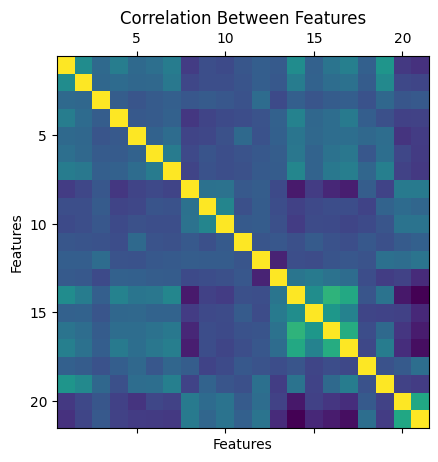

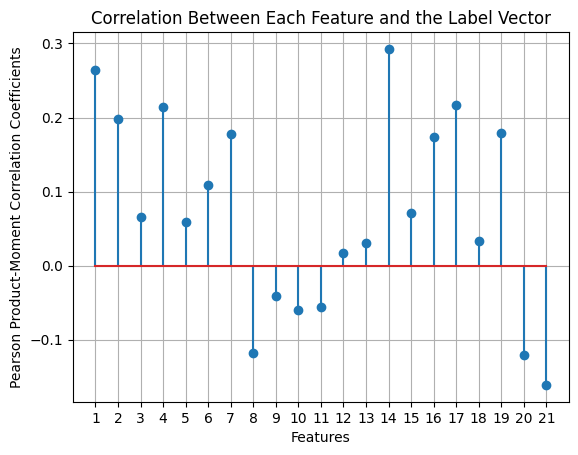

In [99]:
# Import dataset into a pandas dataframe
# Data points classified as "diabetes or pre-diabetes"(1) or "no diabetes"(0)
dataset = pd.read_csv("datasets/binary.csv", dtype="uint8")
# Dataset overview
dataset.info(verbose=True, show_counts=True)

# Divide dataset into training and test sets
train_fraction = 0.8
training, test = train_test_split(dataset, train_fraction)
# Number of data points
print(f"\n\nNumber of data points in train set: {len(training.index)}")
print(f"Number of data points in test set: {len(test.index)}")

# Get X and Y from train and test datasets
# Train
y_train = training["Diabetes"]
X_train = training.drop("Diabetes", axis=1)
# Test
y_test = test["Diabetes"]
X_test = test.drop("Diabetes", axis=1)

# Standardize X
X_train_standardized, X_test_standardized = standardize(X_train, X_test)

# Convert everything from dataframe to ndarray
# Training
X_train_standardized = X_train_standardized.to_numpy()
y_train = y_train.to_numpy().reshape(-1, 1)
# Test
X_test_standardized = X_test_standardized.to_numpy()
y_test = y_test.to_numpy().reshape(-1, 1)

# Split validation set
X_train_standardized, y_train, X_valid_standardized, y_valid = split_validation(
    X_train_standardized, y_train, 0.2
)

# Transpose everything for compatability
# Training
X_train_standardized = np.transpose(X_train_standardized)
y_train = np.transpose(y_train)
print(X_train_standardized.shape)
print(y_train.shape)
# Validation
X_valid_standardized = np.transpose(X_valid_standardized)
y_valid = np.transpose(y_valid)
print(X_valid_standardized.shape)
print(y_valid.shape)
# Test
X_test_standardized = np.transpose(X_test_standardized)
y_test = np.transpose(y_test)
print(X_test_standardized.shape)
print(y_test.shape)

# Get correlation matrix between each feature
corr_coef = np.corrcoef(X_train_standardized)
corr_coef = np.vstack((np.zeros((1, 21)), corr_coef))
corr_coef = np.hstack((np.zeros((22, 1)), corr_coef))
plt.matshow(corr_coef)
plt.title("Correlation Between Features")
plt.xlabel("Features")
plt.ylabel("Features")
ax = plt.gca()
ax.set_xlim([0.5, 21.5])
ax.set_ylim([21.5, 0.5])
plt.show()

# Get correlation vector between every feature and label
correlations = []
for i in range(X_train_standardized.shape[0]):
    corr_matrix = np.corrcoef(X_train_standardized[i,:], y_train[0,:])
    # The correlation coefficient we're interested in is the off-diagonal element
    correlations.append(corr_matrix[0, 1])
plt.stem(range(1, 22), correlations)
plt.title("Correlation Between Each Feature and the Label Vector")
plt.xlabel("Features")
plt.xticks(range(1,22))
plt.ylabel("Pearson Product-Moment Correlation Coefficients")
plt.grid(True)
plt.show()

## Hyperparameter Tuning

Cost after iteration 0: 0.8233486368140988
Cost after iteration 5: 0.35660529910981936
Cost after iteration 10: 0.34469926076491036
Cost after iteration 15: 0.338955980507055
Cost after iteration 20: 0.3355418613405004
Cost after iteration 25: 0.3332116114004415
Cost after iteration 30: 0.3314788396312644
Cost after iteration 35: 0.3301180045511493
Cost after iteration 40: 0.32900508386921423
Cost after iteration 45: 0.328067588189771
Cost after iteration 50: 0.32725962264757213
Cost after iteration 55: 0.32655530624564083
Cost after iteration 60: 0.325933241909673
Cost after iteration 65: 0.32537379724038484
Cost after iteration 0: 0.8743939228317777
Cost after iteration 5: 0.3658778509433952
Cost after iteration 10: 0.34452281002252094
Cost after iteration 15: 0.3370283271292352
Cost after iteration 20: 0.33312173941843265
Cost after iteration 25: 0.33064819580082033
Cost after iteration 30: 0.32888344533593605
Cost after iteration 35: 0.32753363154801063
Cost after iteration 40: 0.3

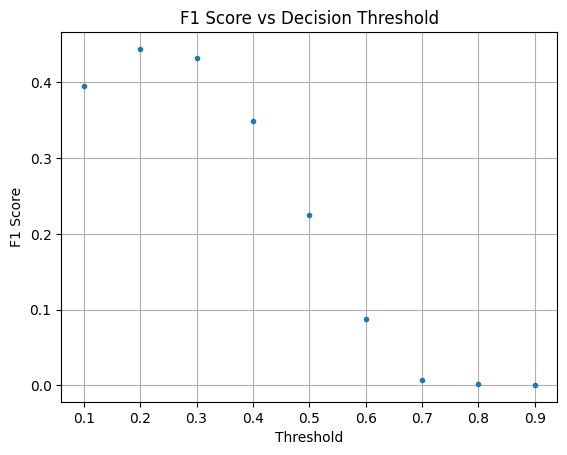

Best threshold: 0.2
Cost after iteration 0: 1.0516526277495286
Cost after iteration 5: 0.8085928056373759
Cost after iteration 10: 0.6743961996783934
Cost after iteration 15: 0.5945870053618707
Cost after iteration 20: 0.5436886614863364
Cost after iteration 25: 0.509287362888404
Cost after iteration 30: 0.484935243464703
Cost after iteration 35: 0.4670533569690348
Cost after iteration 40: 0.45351671325421783
Cost after iteration 45: 0.44300670491478555
Cost after iteration 50: 0.43466140220908983
Cost after iteration 55: 0.42790523081559917
Cost after iteration 60: 0.422331153487675
Cost after iteration 65: 0.41764029381679335
Cost after iteration 70: 0.41361331274356
Cost after iteration 75: 0.41010020165782374
Cost after iteration 80: 0.40697745770256044
Cost after iteration 85: 0.40415828435643075
Cost after iteration 90: 0.40158642749129536
Cost after iteration 95: 0.3992040400595711
Cost after iteration 100: 0.3969813266220245
Cost after iteration 105: 0.39488410488788783
Cost af

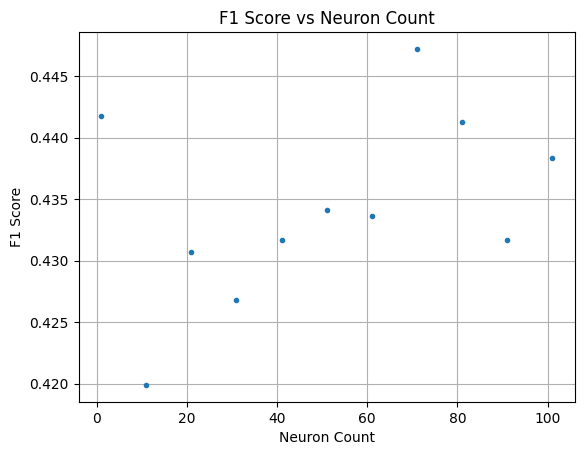

Best neuron count: 71.0
Cost after iteration 0: 1.2770378153729176
Cost after iteration 5: 0.7265653785084809
Cost after iteration 10: 0.5445134342042343
Cost after iteration 15: 0.4710488862966268
Cost after iteration 20: 0.4347321553996458
Cost after iteration 25: 0.41388526325932146
Cost after iteration 30: 0.4005534209776147
Cost after iteration 35: 0.3912984551585839
Cost after iteration 40: 0.3844577712427501
Cost after iteration 45: 0.3791489476334936
Cost after iteration 50: 0.37486286756762527
Cost after iteration 55: 0.3713075050411218
Cost after iteration 60: 0.3682906977217167
Cost after iteration 65: 0.3656841244700917
Cost after iteration 70: 0.3634012762922225
Cost after iteration 75: 0.36137425295187675
Cost after iteration 80: 0.35955864689782385
Cost after iteration 85: 0.35792015026072765
Cost after iteration 90: 0.3564293775583809
Cost after iteration 95: 0.3550683852405477
Cost after iteration 100: 0.3538203293255559
Cost after iteration 105: 0.3526717443165896
Cos

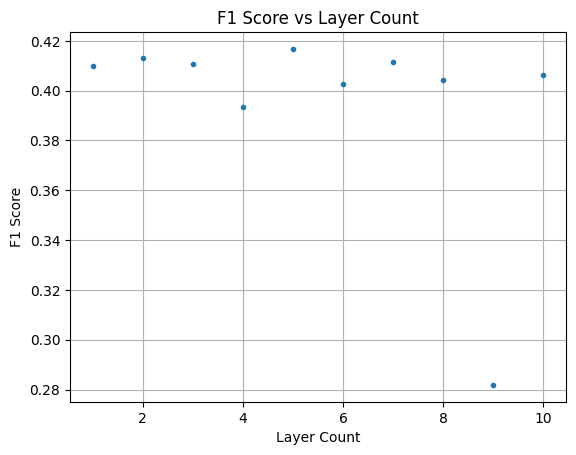

Best layer count: 5.0


In [4]:
best_threshold = tune_threshold(
    X_train_standardized,
    y_train,
    X_valid_standardized,
    y_valid,
    layer_dimensions=[X_train_standardized.shape[0], 21, 1],
    learning_rate=1,
    max_iterations=1000,
    min_cost_delta=0.0001,
    threshold_values=np.arange(0.1, 1.0, 0.1),  # 0.1, 0.2, ..., 0.8, 0.9
)
print(f"Best threshold: {best_threshold}")
best_neuron_count = tune_neuron_count(
    X_train_standardized,
    y_train,
    X_valid_standardized,
    y_valid,
    learning_rate=0.1,
    max_iterations=1000,
    min_cost_delta=0.0001,
    threshold=best_threshold,
    neuron_count_values=np.arange(1, 102, 10),
)
print(f"Best neuron count: {best_neuron_count}")
best_layer_count = tune_layer_count(
    X_train_standardized,
    y_train,
    X_valid_standardized,
    y_valid,
    learning_rate=0.1,
    max_iterations=1000,
    min_cost_delta=0.0001,
    threshold=best_threshold,
    neuron_count=10,
    layer_count_values=np.arange(1, 11, 1),
)
print(f"Best layer count: {best_layer_count}")


## Final Model and Results

Cost after iteration 0: 0.7794487446359815
Cost after iteration 5: 0.3522330368698346
Cost after iteration 10: 0.33651838614905505
Cost after iteration 15: 0.3312565545128106
Cost after iteration 20: 0.3285866590031067
Cost after iteration 25: 0.3268820850944075
Cost after iteration 30: 0.32563831152626554
Cost after iteration 35: 0.3246599145429836
Cost after iteration 40: 0.32384942259989047
Cost after iteration 45: 0.32316110154597244
Cost after iteration 50: 0.322578883790811


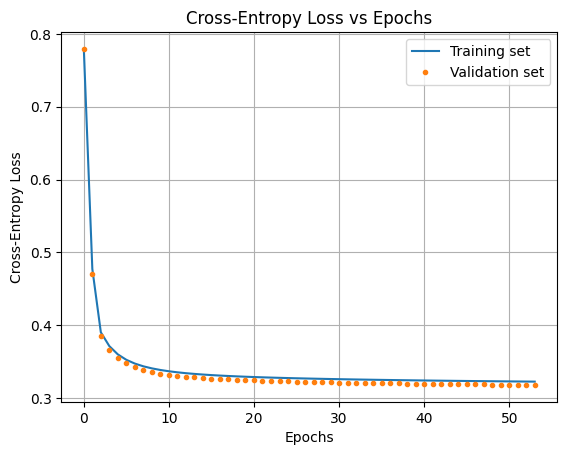

Accuracy: 0.7678916351308736
F1-score: 0.44921249254586487
TN, FP, TP, FN: 136630.0, 37919.0, 19209.0, 9186.0

Accuracy: 0.7701829076001262
F1-score: 0.448282388568184
TN, FP, TP, FN: 34339.0, 9446.0, 4737.0, 2214.0



In [5]:
# Stack validation and training sets
X_train_standardized = np.hstack((X_train_standardized, X_valid_standardized))
y_train = np.hstack((y_train, y_valid))


parameters = train(
    X_train_standardized,
    y_train,
    X_test_standardized,
    y_test,
    layer_dimensions=[X_train_standardized.shape[0], 21, 1],
    learning_rate=1,
    max_iterations=1000,
    min_cost_delta=0.0001,
    validate=True,
    print_cost=True,
    plot=True,
)

predictions = predict(X_train_standardized, parameters, threshold=0.2)
trained_accuracy = get_accuracy(y_train.T, predictions.T)
trained_confusion_matrix = get_confusion_matrix(y_train.T, predictions.T)
trained_f1_score = get_f1_score(y_train.T, predictions.T)
TN, FP, FN, TP = get_confusion_matrix(y_train.T, predictions.T).ravel()
print(
    f"Accuracy: {trained_accuracy}\n"
    f"F1-score: {trained_f1_score}\n"
    f"TN, FP, TP, FN: {TN}, {FP}, {TP}, {FN}\n"
)

predictions = predict(X_test_standardized, parameters, threshold=0.2)
trained_accuracy = get_accuracy(y_test.T, predictions.T)
trained_confusion_matrix = get_confusion_matrix(y_test.T, predictions.T)
trained_f1_score = get_f1_score(y_test.T, predictions.T)
TN, FP, FN, TP = get_confusion_matrix(y_test.T, predictions.T).ravel()
print(
    f"Accuracy: {trained_accuracy}\n"
    f"F1-score: {trained_f1_score}\n"
    f"TN, FP, TP, FN: {TN}, {FP}, {TP}, {FN}\n"
)